## Things to do
 1. More complicated model needs to be implemented (this is the biggest, try modifying the above code for reference)
 2. Model needs to be tuned to match data more closely
 3. (2) might be easier done once we have a more complicated model?
 
## Less Important Things
 4. You could write some analysis of what we are doing to help others reading the notebook
 5. Graphs could look nicer (using plotly or seaborn or just nicer colors)

In [1]:
import sympy
import seaborn as sns
import plotly.express as px

In [2]:
#pip install "notebook>=5.3" "ipywidgets>= 7.2"

In [3]:
# demo of sympy
from sympy.core.symbol import symbols
from sympy.solvers.solveset import nonlinsolve
x, y = symbols('x, y', real=True)
nonlinsolve([4*x, 2*x*y - 6*y**2 + 2*y], [x, y])

FiniteSet((0, 0), (0, 1/3))

In [4]:
# first im ignoring death rate and combining the two infection rates
# suseptible, infected, recovered, and dead
s, i, r, d = symbols('s, i, r, d', real=True)
# b is infection rate
# N is total population
# a (alpha) is rate recovered population turns suseptible again
# d1 is the death rate of infected indivual
b, N, a, d1 = symbols('b, N, a, d1', real=True)
nonlinsolve([(-b*s*i)/N, (b*s*i)/N - r*i - d1*i, r*i - a*r, d1*i], [s, i, r, d])

FiniteSet((s, 0, 0, d))

In [5]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
agency_df = pd.read_csv("https://raw.githubusercontent.com/pfflanders/california-coronavirus-data/master/latimes-state-totals.csv", parse_dates=["date"])
agency_df["date"] = pd.to_datetime(agency_df["date"])

In [7]:
new_df = agency_df[agency_df["date"]>="2021-03-01"]
df = new_df.sort_values(by="date", ignore_index=True)

In [8]:
plt.plot(t, z[4].T)
plt.scatter(agency_df['date'].apply(lambda x: x.value/10**9/60/60/24 - 18287.0), agency_df["deaths"])
plt.xlabel('t')
plt.legend(['d'], shadow=True)
#plt.yscale('log')
plt.title('S-I-R-S-D Infection Model')
plt.show()


NameError: name 't' is not defined

In [ ]:
def simple_sirsd(t, z, N, b, d1, r1, a):
    """
    t: time step
    z: Tuple of ints: (s, i, r, d) 
    b: approximate rate of covid transmission
    N: total population of sim
    a: rate of recovered -> suseptible
    d1: death rate of infected individuals
    
    """
    s, i, r, d = z
    return [
        (-b*s*i)/N + a*r,         # ds/dt
        ( b*s*i)/N - r1*i - d1*i, # di/dt
        r1*i - a*r,               # dr/dt
        d1*i                      # d(dead)/dt
    ]

In [ ]:
def plot_simple_model(N, b, d1, r1, a, steps, real_data=None, log=False):
    """
    Given parameters, plots the corresponding model
    N, b, d1, r1, a: model params
    steps: number of days
    log: should it plotted on a logarithmic scale
    """
    sol = solve_ivp(fun=simple_sirsd, 
                    t_span=[0, steps],
                    y0=[N-100, 1000, 0, 0],
                    args=(N, b, d1, r1, a),
                    dense_output=True)
    t = np.linspace(0, steps, steps)
    z = sol.sol(t)
    plt.plot(t, z.T)

    plt.xlabel('t')
    plt.legend(['s', 'i', 'r', 'd'], shadow=True)
    if log:
        plt.yscale('log')
    if real_data is not None:
        plt.scatter(real_data['date'].apply(lambda x: x.value/10**9/60/60/24 - 18287.0), real_data["deaths"])
    plt.title('S-I-R-S-D Infection Model')
    plt.show()

In [ ]:
N = 40000000 # population of california

b = 0.05 # terrible approximation of rate of covid transmission. 
d1 = 0.0001 # approx death rate of covid
r1 = 0.02 # rate of infected population recovering
a = 0.02 # rate of recovered -> suseptible

steps = 584 # days since start of covid (according to our data)

plot_simple_model(N, b, d1, r1, a, steps, real_data=agency_df, log=True)

In [9]:
def sirsd(t, z, b1, b2, d1, r1, a):
    """
    t: time step
    z: Tuple of ints: (s, i, r, d) 
    b: approximate rate of covid transmission
    N: total population of sim
    a: rate of recovered -> suseptible
    d1: death rate of infected individuals
    
    """
    N = 40000000
    s1, s2, i, r, d = z
    return [
        (-b1*s1*i)/N + a*r + 0.001*t,              # ds1/dt
        (-b2*s2*i)/N - 0.001*t,                    # ds2/dt
        (b1*s1*i)/N + (b2*s2*i)/N - r1*i - d1*i,   # di/dt
        r1*i - a*r,                                # dr/dt
        d1*i                                       # d(dead)/dt
    ]

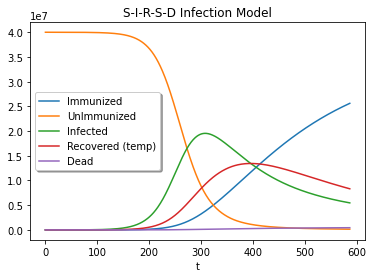

In [10]:
N = 40000000 # population of california

b1 = 0.01 # vaccinated approximation of rate of covid transmission. 
b2 = 0.05 # terrible approximation of rate of covid transmission. 
d1 = 0.0001 # approx death rate of covid
r1 = 0.01 # rate of infected population recovering
a = 0.01 # rate of recovered -> suseptible

steps = 586 # days since start of covid (according to our data)

sol = solve_ivp(fun=sirsd, 
                t_span=[0, steps],
                y0=[0, N-100, 1000, 0, 0],
                args=(b1, b2, d1, r1, a),
                dense_output=True)

t = np.linspace(0, steps, steps)
z = sol.sol(t)
plt.plot(t, z.T)

plt.xlabel('t')
plt.legend(['Immunized', 'UnImmunized', 'Infected', 'Recovered (temp)', 'Dead'], shadow=True)
plt.title('S-I-R-S-D Infection Model')
plt.show()


In [11]:
z.T

array([[0.00000000e+00, 3.99999000e+07, 1.00000000e+03, 0.00000000e+00,
        0.00000000e+00],
       [5.11791565e-02, 3.99998489e+07, 1.04077752e+03, 1.01692923e+01,
        1.02199698e-01],
       [2.06789926e-01, 3.99997957e+07, 1.08321784e+03, 2.06519185e+01,
        2.08567016e-01],
       ...,
       [2.55164061e+07, 1.50046916e+05, 5.50849700e+06, 8.37992507e+06,
        4.46024967e+05],
       [2.55650347e+07, 1.49016760e+05, 5.48906463e+06, 8.35120812e+06,
        4.46575785e+05],
       [2.56134334e+07, 1.47997270e+05, 5.46976028e+06, 8.32258439e+06,
        4.47124662e+05]])

In [12]:
df=pd.DataFrame(z.T, columns = ['Immunized','Unimmunized','Infections', 'Recovery', 'Deaths'])

In [13]:
df

,Immunized,Unimmunized,Infections,Recovery,Deaths
0,0.000000e+00,3.999990e+07,1.000000e+03,0.000000e+00,0.000000
1,5.117916e-02,3.999985e+07,1.040778e+03,1.016929e+01,0.102200
2,2.067899e-01,3.999980e+07,1.083218e+03,2.065192e+01,0.208567
3,4.700534e-01,3.999974e+07,1.127389e+03,3.146172e+01,0.319273
4,8.442960e-01,3.999968e+07,1.173361e+03,4.261295e+01,0.434492
...,...,...,...,...,...
581,2.541846e+07,1.521398e+05,5.547750e+06,8.437637e+06,444917.459526
582,2.546755e+07,1.510879e+05,5.528059e+06,8.408735e+06,445472.196409
583,2.551641e+07,1.500469e+05,5.508497e+06,8.379925e+06,446024.967178
584,2.556503e+07,1.490168e+05,5.489065e+06,8.351208e+06,446575.784715


In [14]:
df['Days'] = df.index +1
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [15]:
df_melt = df.melt(id_vars='Days', value_vars=['Immunized', 'Unimmunized', 'Infections', 'Recovery', 'Deaths'])

In [16]:
df_melt

,Days,variable,value
0,1,Immunized,0.000000
1,2,Immunized,0.051179
2,3,Immunized,0.206790
3,4,Immunized,0.470053
4,5,Immunized,0.844296
...,...,...,...
2925,582,Deaths,444917.459526
2926,583,Deaths,445472.196409
2927,584,Deaths,446024.967178
2928,585,Deaths,446575.784715


In [29]:
fig = px.line(df_melt, x='Days' , y='value' , color='variable')
fig.update_layout(
    title="S-I-R-S-D Infection Model",
    xaxis_title="Time (in days)",
    yaxis_title="Population",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"))
fig.show()


In [18]:
from math import sqrt
deaths_data = np.array(agency_df["deaths"].sort_values())


In [19]:
def compute_z(initial_vars, steps):
    #print("begin computing z")
    sol = solve_ivp(fun=sirsd, 
                    t_span=[0, steps],
                    y0=[0, N-100, 1000, 0, 0],
                    args=initial_vars,
                    dense_output=True)

    t = np.linspace(0, steps, steps)
    z = sol.sol(t)
    #print("end computing z")
    return z

In [20]:
def mse(initial_vars):
    #print("begin mse")
    #print(initial_vars)
    if any(x < 0 for x in initial_vars):
        return 100000000
    steps = 584 # days since start of covid (according to our data)
    z = compute_z(initial_vars, steps)
    mean_sqaure_error = 0
    for i in range(len(z[4])):
        mean_sqaure_error += (z[4][i] - deaths_data[i])**2
    #print("end mse")
    return sqrt(mean_sqaure_error)

In [21]:
Nfeval = 0
def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3], Xi[4], mse(Xi)))
    Nfeval += 1

In [22]:
def constraint(vars):
    return all(x > 0.01 for x in vars)


In [23]:
from scipy.optimize import minimize
N = 40000000 # population of california

b1 = 0.01 # vaccinated approximation of rate of covid transmission. 
b2 = 0.05 # terrible approximation of rate of covid transmission. 
d1 = 0.0001 # approx death rate of covid
r1 = 0.01 # rate of infected population recovering
a = 0.01 # rate of recovered -> suseptible

print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}'.format('Iter', ' X1', ' X2', ' X3', 'f(X)')   )

initial_vars = (b1, b2, d1, r1, a)
z_ = minimize(mse, 
              initial_vars, 
              callback=callbackF, 
              options={"maxiter":200, "disp":True},
              #constraints={'type': 'ineq', 'fun': lambda x: x > 0}
             )
z_

Iter    X1          X2          X3         f(X)     
   0    0.010000    0.050000    0.000017    0.010001
   1    0.010006    0.050018    0.000016    0.009932
   2    0.008098    0.055538    0.000016    0.011005
   3    0.001083    0.052808    0.000016    0.009358
   4    0.000538    0.052753    0.000016    0.009330
         Current function value: 125241.297125
         Iterations: 5
         Function evaluations: 417
         Gradient evaluations: 68


      fun: 125241.29712489131
 hess_inv: array([[ 1.39612916e-06,  3.35283674e-07,  7.81247748e-12,
         1.96839734e-07, -3.48010559e-07],
       [ 3.35283702e-07,  8.11415434e-08,  1.95158934e-12,
         4.74443514e-08, -8.33779363e-08],
       [ 7.81248828e-12,  1.95159205e-12,  8.61133904e-17,
         1.14001522e-12, -1.93192690e-12],
       [ 1.96839745e-07,  4.74443502e-08,  1.14001373e-12,
         2.78359064e-08, -4.86867984e-08],
       [-3.48010352e-07, -8.33778797e-08, -1.93192435e-12,
        -4.86867674e-08,  9.13364863e-08]])
      jac: array([-1.98409419e+05,  4.36932909e+06,  4.49764454e+09, -5.75509145e+06,
       -1.71828770e+04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 417
      nit: 5
     njev: 68
   status: 2
  success: False
        x: array([5.37800647e-04, 5.27532071e-02, 1.61146461e-05, 9.33000517e-03,
       5.48062486e-03])

In [24]:
z_.x

array([5.37800647e-04, 5.27532071e-02, 1.61146461e-05, 9.33000517e-03,
       5.48062486e-03])

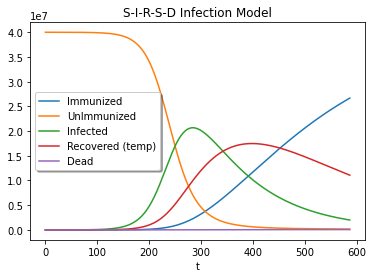

In [25]:
sol = solve_ivp(fun=sirsd, 
                t_span=[0, steps],
                y0=[0, N-100, 1000, 0, 0],
                args=z_.x,
                dense_output=True)

t = np.linspace(0, steps, steps)
z = sol.sol(t)
plt.plot(t, z.T)

plt.xlabel('t')
plt.legend(['Immunized', 'UnImmunized', 'Infected', 'Recovered (temp)', 'Dead'], shadow=True)
plt.title('S-I-R-S-D Infection Model')
plt.show()

In [26]:
z_.x

array([5.37800647e-04, 5.27532071e-02, 1.61146461e-05, 9.33000517e-03,
       5.48062486e-03])

In [27]:
# b1
# b2
# birth =0 
# v vaccinated rate
# di
# d0
# r
# alpha
# N

In [28]:

b1 = 0.01 # vaccinated approximation of rate of covid transmission. 
b2 = 0.05 # terrible approximation of rate of covid transmission. 
d1 = 0.0001 # approx death rate of covid
r1 = 0.01 # rate of infected population recovering
a = 0.01 # rate of recovered -> suseptible
